In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#for ML preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#neural network
from tensorflow import keras
from tensorflow.keras import layers
from keras import optimizers
#random forest classifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV #for gridsearch of rf
#evaluation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Neural Net Analysis
import shap

import MLACDS as dt #diffusion simulation tools

pd.set_option('display.max_columns', None)

2024-02-07 14:30:21.344502: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Files with useable data:
'p0.1_N54/'
'p0.2_N54/'
'p0.3_N500/'

In [2]:
N_neighbours = 8 ### number of neighbours to be extracted

# dires = ["p0.1_N54/","p0.2_N54/"] #data we want to load for training
# dires = ["p0.3_N500/"] #not compatible with above two due to different particles

dires = ['p0.1_N54/', 'p0.2_N54/'] 

In [3]:
#### list with names to be used in the final dataframe
l_s = list(range(N_neighbours))
l_s_names = []


for i in l_s:
    l_s_names.append('l'+str(i)+"_inv")

for i in l_s:
    l_s_names.append('l'+str(i))


In [4]:
l_s_names

['l0_inv',
 'l1_inv',
 'l2_inv',
 'l3_inv',
 'l4_inv',
 'l5_inv',
 'l6_inv',
 'l7_inv',
 'l0',
 'l1',
 'l2',
 'l3',
 'l4',
 'l5',
 'l6',
 'l7']

In [5]:
### list of columns for bond order parameter
bo = list(range(N_neighbours))
bo_names = []
for i in bo:
    bo_names.append("bo"+str(i))

In [6]:
f_r_cut_vol = 4### cut off used for the local volume calculation
# radius of local volume spher 
#keep @ 4 too small too little neighbour

f_r_cut_sp = 30###A big number here means look for the closest 
                #neighbours
               ###For a small cut-off the number of neighbours
                #might not be the same for all particles


In [7]:
# df = dt.load_data(dires, l_s, l_s_names, bo, bo_names, f_r_cut_vol, f_r_cut_sp, N_neighbours)
df = pd.read_csv("data/csv_files/diffusion_data.csv")

In [8]:
# df.to_csv("data/csv_files/diffusion_data.csv", index=False)

In [9]:
df.columns

Index(['l0_inv', 'l1_inv', 'l2_inv', 'l3_inv', 'l4_inv', 'l5_inv', 'l6_inv',
       'l7_inv', 'l0', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'l7', 'bo0', 'bo1',
       'bo2', 'bo3', 'bo4', 'bo5', 'bo6', 'bo7', 'vol', 'n_neighbours', 'Ds'],
      dtype='object')

In [10]:
df = df.drop(['l0', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'l7', ], axis=1)

## Data Preprocessing

In [11]:
data = df.iloc[:,:-1]

In [12]:
target = df.Ds

In [13]:
#splitting the data to train and test
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=13, test_size=0.4)

In [14]:
#scaling data based on training set to prevent data leakage, the scaler computed from training set statistics will be applied to test data
scaler = preprocessing.StandardScaler().fit(X_train)

In [15]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
X_train_scaled.shape

(9720, 18)

## NN Model

In [17]:
#the first nn model. This contains:
model = keras.Sequential([
    layers.Dense(32, input_shape=(18,), activation="relu"), #input layer
    layers.Dense(16, activation="relu"), #first hidden layer less nodes
    layers.Dropout(0.5), #dropout layer with 50% dropout to prevent overfitting
    layers.Dense(1) #output layer, no activation function as must be continuous
])

2024-02-07 14:30:23.955816: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                608       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [19]:
# # Compile the model
model.compile(optimizer=optimizers.RMSprop(),
                loss='mse',
                metrics=['mae'])

In [20]:
# # Compile the model
# model.compile(optimizer=optimizers.SGD(),
#                 loss='mse',
#                 metrics=['mae'])

In [21]:
#train the model (this takes a little while)
history = model.fit(X_train_scaled, y_train,
                    epochs=100, 
                    batch_size=32,
                    validation_data=(X_test_scaled, y_test))

Epoch 1/100
304/304 [==============================] - 2s 5ms/step - loss: 0.1345 - mae: 0.2585 - val_loss: 0.0083 - val_mae: 0.0756
Epoch 2/100
304/304 [==============================] - 1s 3ms/step - loss: 0.0078 - mae: 0.0670 - val_loss: 0.0019 - val_mae: 0.0359
Epoch 3/100
304/304 [==============================] - 1s 3ms/step - loss: 0.0028 - mae: 0.0435 - val_loss: 0.0015 - val_mae: 0.0321
Epoch 4/100
304/304 [==============================] - 1s 3ms/step - loss: 0.0025 - mae: 0.0401 - val_loss: 0.0012 - val_mae: 0.0280
Epoch 5/100
304/304 [==============================] - 1s 3ms/step - loss: 0.0021 - mae: 0.0369 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 6/100
304/304 [==============================] - 1s 3ms/step - loss: 0.0021 - mae: 0.0363 - val_loss: 9.9815e-04 - val_mae: 0.0262
Epoch 7/100
304/304 [==============================] - 1s 2ms/step - loss: 0.0020 - mae: 0.0362 - val_loss: 9.3133e-04 - val_mae: 0.0252
Epoch 8/100
304/304 [==============================] - 1s 3ms

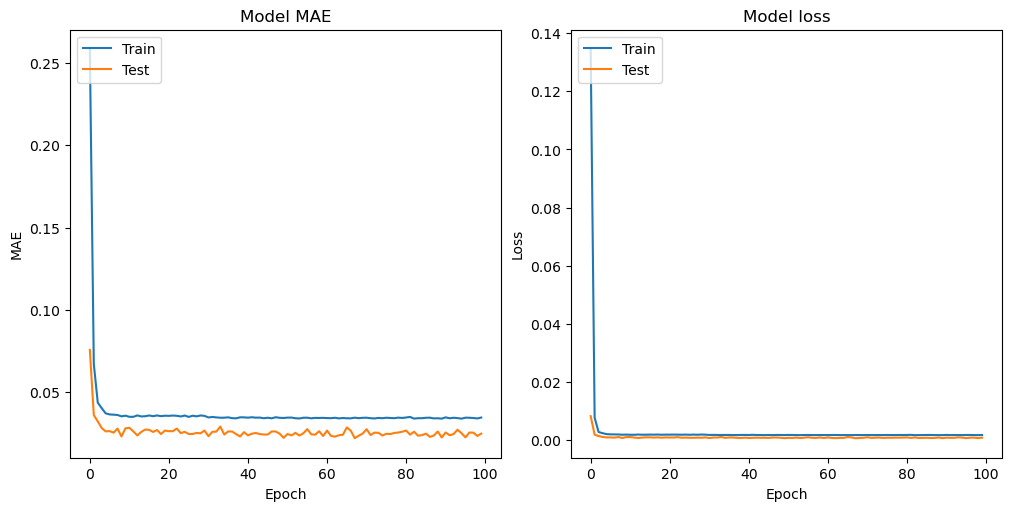

In [22]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10,5), layout="constrained", sharex=True)

axs[0].plot(history.history['mae'])
axs[0].plot(history.history['val_mae'])
axs[0].set_title('Model MAE')
axs[0].set_ylabel('MAE')
axs[0].set_xlabel('Epoch')
# axs[0].set_ylim(0,0.01)
axs[0].legend(['Train', 'Test'], loc='upper left')

axs[1].plot(history.history['loss']) 
axs[1].plot(history.history['val_loss']) 
axs[1].set_title('Model loss') 
axs[1].set_ylabel('Loss') 
axs[1].set_xlabel('Epoch') 
axs[1].legend(['Train', 'Test'], loc='upper left') 

plt.show()

In [23]:
# load JS visualization for notebook vis
shap.initjs()

In [24]:
background = shap.sample(X_train_scaled, 100)

In [25]:
explainer = shap.KernelExplainer(model.predict, background)

4/4 [==============================] - 0s 11ms/step


In [26]:
shap_values = explainer.shap_values(X_test_scaled[:50], nsamples=50)

  0%|          | 0/50 [00:00<?, ?it/s]

157/157 [==============================] - 0s 2ms/step


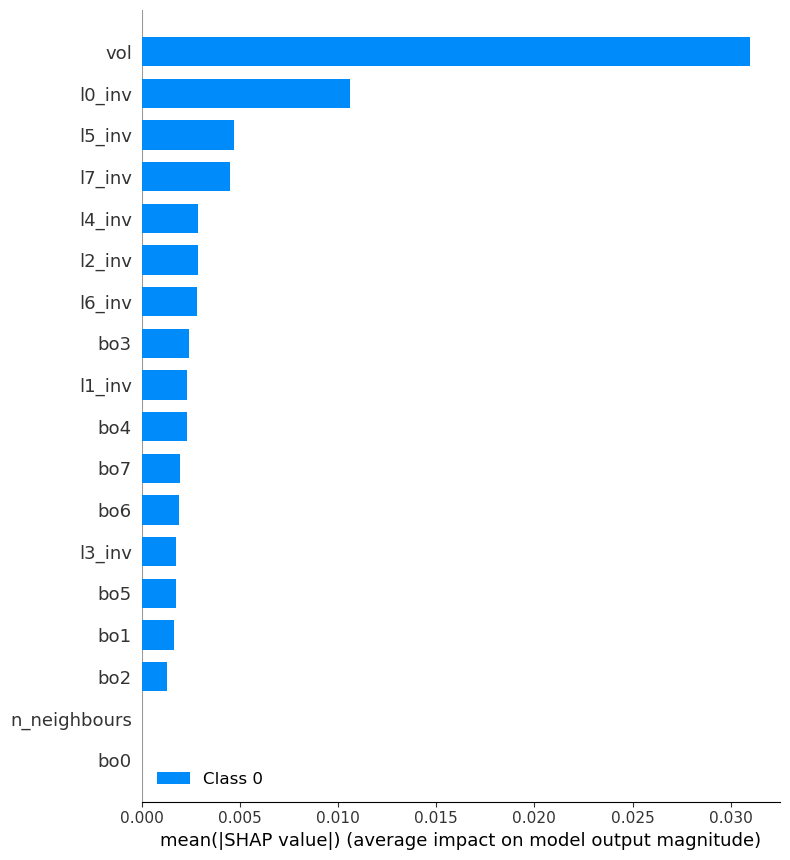

In [27]:
shap.summary_plot(shap_values, X_test_scaled, feature_names=data.columns)

In [28]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test_scaled[:100], feature_names=data.columns)

In [29]:
y_pred_nn = model.predict(X_test_scaled).ravel()

203/203 [==============================] - 0s 2ms/step


In [30]:
nn_r2 = r2_score(y_test, y_pred_nn)

nn_mae = mean_absolute_error(y_test, y_pred_nn)
nn_mse = mean_squared_error(y_test, y_pred_nn)
nn_rmse = np.sqrt(nn_mse)


In [31]:
print("NN Model R2:", nn_r2)
print("NN Model MAE:", nn_mae)
print("NN Model MSE:", nn_mse)
print("NN Model RMSE:", nn_rmse)

NN Model R2: 0.8521212890058146
NN Model MAE: 0.024605157163879815
NN Model MSE: 0.0009109920292424649
NN Model RMSE: 0.030182644503794973


## Random Forest

In [53]:
# gridsearch to give good challenge to neural net

params = {
    "n_estimators":[200,300,400],
    "criterion":(["squared_error"]),# "absolute_error"),
    "max_depth":[6,12,18]
         } 

rf = RandomForestRegressor()

clf = GridSearchCV(rf, params, verbose=1)

In [54]:
# #fitting the model
clf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error'],
                         'max_depth': [6, 12, 18],
                         'n_estimators': [200, 300, 400]},
             verbose=1)

In [55]:
clf.best_params_

{'criterion': 'squared_error', 'max_depth': 6, 'n_estimators': 300}

In [56]:
#run this cell instead of the gridsearch to save alot of time.
# clf = RandomForestRegressor(criterion="squared_error", max_depth=14, n_estimators=300)

# clf.fit(X_train_scaled, y_train)

In [57]:
# #this was from diff gridsearch
# clf = RandomForestRegressor(criterion="squared_error", max_depth=18, n_estimators=500)

# clf.fit(X_train_scaled, y_train)

In [58]:
def sort_list(list1, list2): #function from geeksforgeeks.org
    zipped_pairs = zip(list2, list1)
    z = [x for _, x in sorted(zipped_pairs, reverse=True)]
    return z

In [59]:
rf_feat_imp = clf.feature_importances_
feat_names = data.columns

ranked_feat_names = sort_list(feat_names, rf_feat_imp)

ranked_rf_feature_imp = sorted(rf_feat_imp, reverse=True)

fig, ax = plt.subplots(figsize=(18,4))
ax.bar(ranked_feat_names, ranked_rf_feature_imp)
plt.title("Feature Importance for Random Forest Regressor")
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

In [ ]:
#predictions
y_pred_rf = clf.predict(X_test_scaled)

In [ ]:
rf_r2 = r2_score(y_test, y_pred_rf)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)


In [ ]:
print("RF Model R2:", rf_r2)
print("RF Model MAE:", rf_mae)
print("RF Model MSE:", rf_mse)
print("RF Model RMSE:", rf_rmse)

## Volume Correction

In [ ]:
VC_pred = dt.VolumeCorrection(X_test.vol)

In [ ]:
VC_r2 = r2_score(y_test, VC_pred)

VC_mae = mean_absolute_error(y_test, VC_pred)
VC_mse = mean_squared_error(y_test, VC_pred)
VC_rmse = np.sqrt(VC_mse)

In [ ]:
print("VC Model R2:", VC_r2)
print("VC Model MAE:", VC_mae)
print("VC Model MSE:", VC_mse)
print("VC Model RMSE:", VC_rmse)

## Looking at Metrics and Predictions

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8), layout="constrained")
models = ["Vol. Correction", "Rand. Forest", "Neural Net."]
r2_metric = [VC_r2, rf_r2, nn_r2]
mae_metric = [VC_mae, rf_mae, nn_mae]
mse_metric = [VC_mse, rf_mse, nn_mse]
rmse_metric = [VC_rmse, rf_rmse, nn_rmse]

axs[0][0].bar(models, r2_metric)
axs[0][1].bar(models, mae_metric)
axs[1][0].bar(models, mse_metric)
axs[1][1].bar(models, rmse_metric)

axs[0][0].set_title("R2 Score (Higher is Better)")
axs[0][1].set_title("MAE (Lower is Better)")
axs[1][0].set_title("MSE (Lower is Better)")
axs[1][1].set_title("RMSE (Lower is Better)")

plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4), layout="constrained")#, sharex=True, sharey=True)

im0 = axs[0].hist2d(y_test, VC_pred, bins=50, cmap="magma")
im1 = axs[1].hist2d(y_test, y_pred_rf, bins=50, cmap="cividis")
im2 = axs[2].hist2d(y_test, y_pred_nn, bins=50)

axs[0].plot([0,1],[0,1], "w--")
axs[1].plot([0,1],[0,1], "w--")
axs[2].plot([0,1],[0,1], "w--")

fig.colorbar(im0[3], ax=axs[0])
fig.colorbar(im1[3], ax=axs[1])
fig.colorbar(im2[3], ax=axs[2])

axs[0].set_xlabel("True Value")
axs[0].set_ylabel("Volume Correction Prediction")

axs[1].set_xlabel("True Value")
axs[1].set_ylabel("Random Forest Prediction")

axs[2].set_xlabel("True Value")
axs[2].set_ylabel("Neural Network Prediction")

plt.show()

In [ ]:
plt.plot(y_test, y_test, ".", label="Target")
plt.plot(y_test, VC_pred, ".", label="Volume Correction")
plt.plot(y_test, y_pred_rf, ".", label="Random Forest")
plt.plot(y_test, y_pred_nn, ".", label="Neural Network")
plt.xlabel("True Value")
plt.ylabel("Model Prediction")
plt.legend()
plt.show()

In [ ]:
#this plot is a bit of a mess
plt.plot(X_test.vol, y_test, ".", label="Target")
plt.plot(X_test.vol, VC_pred, ".", label="Volume Correction", alpha=0.5)
plt.plot(X_test.vol, y_pred_rf, ".", label="Random Forest", alpha=0.5)
plt.plot(X_test.vol, y_pred_nn, ".", label="Neural Network", alpha=0.5)
plt.xlabel("Local Volume")
plt.ylabel("Diffusion Parameter")
plt.legend()
plt.show()

In [ ]:
ind = 20
num = 1

plt.plot(X_test.vol[ind:ind+num], VC_pred[ind:ind+num], ".", label="Volume Correction")
plt.plot(X_test.vol[ind:ind+num], y_pred_rf[ind:ind+num], ".", label="Random Forest")
plt.plot(X_test.vol[ind:ind+num], y_pred_nn[ind:ind+num], ".", label="Neural Network")
plt.plot(X_test.vol[ind:ind+num], y_test[ind:ind+num], ".", label="Target")
# plt.xlim(0.12, 0.26)
# plt.ylim(0.3, 0.475)
plt.legend()
plt.show()